In [1]:
from distributed import Nanny
from matplotlib.pyplot import contour
from networkx.algorithms.bipartite.basic import color

# Dataset Directory

dataset_folder = '/mnt/Data1/Nick/transcription_pipeline/'

Rpb1_datasets = [
    "test_data/2024-10-11/Halo552_Rpb1_embryo03"
]

Dl_datasets = [
    "test_data/2024-11-08/Dl-Halo552_MCP-GFP_twiPE_embryo01",
    "test_data/2024-11-20/Dl-Halo552_MCP-GFP_twiPE_embryo01",
    "test_data/2024-06-11/Dl-Halo552-DeltadsRed_embryo01"
]

Dl_datasets_2D = [
    "test_data/"
]

test_dataset_name = dataset_folder + Dl_datasets[2]
print('Dataset Path: ' + test_dataset_name)

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/2024-06-11/Dl-Halo552-DeltadsRed_embryo01


In [2]:
# Import pipeline
from transcription_pipeline import nuclear_pipeline
from transcription_pipeline import preprocessing_pipeline

from transcription_pipeline import spot_pipeline
from transcription_pipeline import fullEmbryo_pipeline

# Importing libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from transcription_pipeline.spot_analysis import compile_data
from transcription_pipeline.utils import plottable

from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

import numpy as np
from scipy.optimize import least_squares
from scipy.stats import chi2
import pandas as pd
from IPython.display import display
import emcee
import os
from warnings import warn
import tkinter as tk
from tkinter import simpledialog
from tkinter import messagebox

root = tk.Tk()
root.withdraw();

`JAVA_HOME` environment variable set to /mnt/Data1/Nick/miniforge3/envs/transcription_pipeline


In [3]:
mpl.use('TkAgg')
# %matplotlib widget

In [3]:
ms2_import_previous = os.path.isdir(test_dataset_name + '/collated_dataset')
ms2_import_previous

True

In [4]:
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    working_storage_mode='zarr',
    import_previous=ms2_import_previous, 
)

In [ ]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="10GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

In [ ]:
client.restart()

In [ ]:
client.shutdown()

In [ ]:
print(client.dashboard_link)

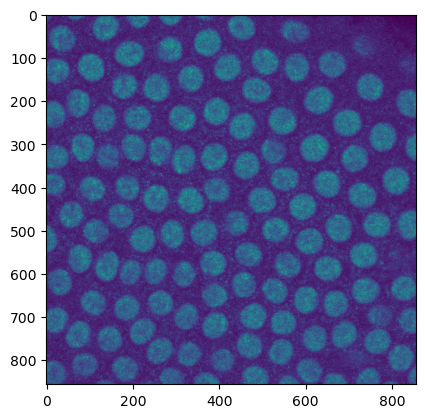

In [37]:
# Plot both channels of the movie in line

%matplotlib inline
time_frame = 3
z_slice = 6

plt.figure()
plt.imshow(dataset.channels_full_dataset[0][time_frame, z_slice, :, :])
plt.show()


In [6]:
# Set the channels for spot and nuclear tracking
# spot_channel = 0
nuclear_channel = 0

## Nuclear Tracking

In [7]:
nuclear_tracking_previous = os.path.isdir(test_dataset_name + '/nuclear_analysis_results')
nuclear_tracking_previous

True

In [8]:
if nuclear_tracking_previous:
    # Load nuclear tracking results
    print('Load from previous nuclear tracking results')
    
    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)
    
else:
    # Do nuclear tracking and save the results
    print('Do nuclear tracking for the dataset')
    
    nuclear_tracking = nuclear_pipeline.Nuclear(
        data=dataset.channels_full_dataset[nuclear_channel],
        global_metadata=dataset.export_global_metadata[nuclear_channel],
        frame_metadata=dataset.export_frame_metadata[nuclear_channel],
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        search_range_um=1.5,
        stitch=False,
        stitch_max_distance=4,
        stitch_max_frame_distance=2,
        client=client,
        keep_futures=False,
    )
    
    nuclear_tracking.track_nuclei(
            working_memory_mode="zarr",
            working_memory_folder=test_dataset_name,
            trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
        )
        # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
        # tracking information.
    nuclear_tracking.save_results(
            name_folder=test_dataset_name, save_array_as=None
        )

Load from previous nuclear tracking results


In [9]:
    # Load nuclear tracking results
    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)

In [10]:
nuclear_tracking.mitosis_dataframe.head()

,label,z,y,x,nuclear_intensity_mean,nuclear_intensity_stdev,frame,original_frame,t_s,t_frame,nuclear_cycle,y_pixel,x_pixel,particle,v_z,v_y,v_x,parent
0,2,5.791629,25.361873,75.079717,8.791766,3.093444,17,17,357.609001,16,13,234.601947,694.501078,1,0.075881,0.041802,-0.005999,<NA>
1,3,5.930239,21.945490,90.250722,9.094609,3.154204,17,17,357.609001,16,13,202.999786,834.835641,2,-0.002155,0.023843,-0.059296,<NA>
2,4,6.002367,32.987691,43.495270,8.857324,3.081485,17,17,359.422001,16,13,305.142157,402.339183,3,-0.094559,-0.165512,-0.227113,<NA>
3,5,5.636507,54.944557,80.932948,9.139921,3.200934,17,17,357.609001,16,13,508.247175,748.644525,4,-0.264283,-0.630347,0.041551,<NA>
4,6,5.828626,81.841366,89.371474,9.687061,3.392035,17,17,357.609001,16,13,757.047566,826.702432,5,0.132085,-0.778621,-0.088716,<NA>


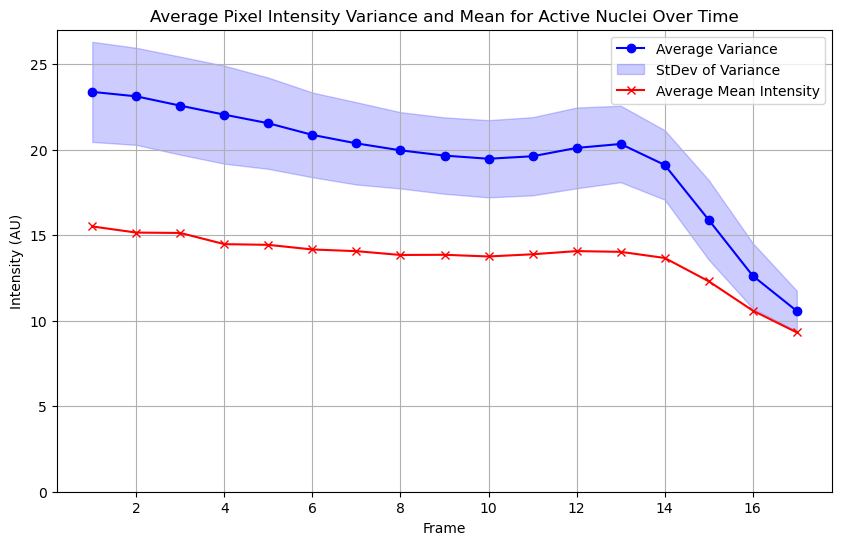

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_timewise_nucleus_intensity_variance_with_sem(df, data, mask, start_time, end_time):
    """
    Plots the mean pixel intensity variance and mean intensity over time,
    with the standard error of the mean (SEM) for the variance shown as a shaded region.

    Parameters:
    df (pd.DataFrame): DataFrame containing centroid coordinates ('time', 'z', 'y', 'x') in pixels.
    data (np.ndarray): 4D dataset with shape (t, z, y, x).
    mask (np.ndarray): 3D mask with labeled nuclei.
    start_time (int): Start time frame.
    end_time (int): End time frame.
    """
    timepoints = np.arange(start_time, end_time + 1)
    mean_variances = []
    sem_variances = []  # Standard error of the mean for variances
    mean_intensities = []
    
    for t in timepoints:
        # Filter for nuclei active at the current time point
        nuclei_at_t = df[df['frame'] == t]
        
        if nuclei_at_t.empty:
            mean_variances.append(np.nan)
            sem_variances.append(np.nan)
            mean_intensities.append(np.nan)
            continue
        
        # Calculate variance and mean intensity for all active nuclei at this time
        variances_at_t = (nuclei_at_t['nuclear_intensity_stdev']**2).to_numpy()
        intensities_at_t = nuclei_at_t['nuclear_intensity_mean'].to_numpy()
        
        # Average over all active nuclei
        mean_variances.append(np.mean(variances_at_t))
        mean_intensities.append(np.mean(intensities_at_t))
        
        # Calculate SEM for the variance
        sem_variances.append(np.std(variances_at_t))# / np.sqrt(len(variances_at_t)))
    
    # Plot mean variance with SEM as shaded region
    plt.figure(figsize=(10, 6))
    plt.plot(timepoints, mean_variances, label='Average Variance', color='blue', marker='o')
    plt.fill_between(timepoints,
                     np.array(mean_variances) - np.array(sem_variances),
                     np.array(mean_variances) + np.array(sem_variances),
                     color='blue', alpha=0.2, label='StDev of Variance')
    
    # Plot mean intensity over time with Stdev as shaded region
    # plt.figure(figsize=(10, 6))
    plt.plot(timepoints, mean_intensities, label='Average Mean Intensity', color='red', marker='x')
    # plt.fill_between(timepoints,
    #                     np.array(mean_intensities) - np.sqrt(mean_variances),
    #                     np.array(mean_intensities) + np.sqrt(mean_variances),
    #                     color='red', alpha=0.2, label='StDev of Intensity')
    
    # Plot details
    plt.title(f'Average Pixel Intensity Variance and Mean for Active Nuclei Over Time')
    plt.xlabel('Frame')
    plt.ylabel('Intensity (AU)')
    plt.ylim(0, 27)
    plt.legend()
    plt.grid(True)
    plt.show()


    
start_frame=0
end_frame=17
plot_timewise_nucleus_intensity_variance_with_sem(nuclear_tracking.mitosis_dataframe, 
                                dataset.channels_full_dataset[0], 
                                nuclear_tracking.reordered_labels, 
                                start_frame,
                                end_frame)


In [27]:
nuclear_tracking.reordered_labels

<zarr.core.Array (17, 12, 856, 856) uint32>

In [27]:
from skimage.measure import label
import numpy as np
from scipy.ndimage import gaussian_filter
import pandas as pd
import matplotlib.pyplot as plt

# Process a single nuclear slice
def process_nuclear_slice(frame_nuclear_labels, frame_nuclear_data, nucleus_id, sigma_xy=0, z_plane=None):
    # Mask and extract nucleus data
    nucleus_mask = (frame_nuclear_labels == nucleus_id)
    nucleus_mask_data = frame_nuclear_data * nucleus_mask

    # Get the z-plane with maximum intensity
    if z_plane is None:
        z_plane = np.argmax(np.sum(nucleus_mask_data, axis=(1, 2)))
        z_plane_data = nucleus_mask_data[z_plane, :, :]
    else:
        z_plane_data = nucleus_mask_data[z_plane, :, :]
    
    # Check if nucleus is present in the z-plane
    if not np.any(z_plane_data):
        print(f"No data found for nucleus {nucleus_id} in z-plane {z_plane}.")
        return None, None, None, None, None, None

    # Crop z-plane to the bounding box of the nucleus
    nucleus_bbox = np.array(np.where(z_plane_data)).T
    min_y, min_x = np.min(nucleus_bbox, axis=0)
    max_y, max_x = np.max(nucleus_bbox, axis=0)
    cropped_nucleus_slice = z_plane_data[min_y:max_y + 1, min_x:max_x + 1]

    # Apply Gaussian blur
    blurred_nucleus_slice = gaussian_filter(np.nan_to_num(cropped_nucleus_slice),
                                            sigma=sigma_xy, mode='constant')

    return cropped_nucleus_slice, blurred_nucleus_slice, z_plane_data, z_plane, min_y, max_y, min_x, max_x

# Segment clusters and optionally plot results
def segment_clusters(dataset, nuclear_tracking, nuclear_channel, frame, nucleus_id, sigma_xy=1, z_plane=None, contour_cutoff=8, plot=False):
    frame_nuclear_labels = nuclear_tracking.reordered_labels[frame, :, :]
    frame_nuclear_data = dataset.channels_full_dataset[nuclear_channel][frame, :, :]

    (cropped_nucleus_slice,
     blurred_nucleus_slice,
     z_plane_data,z_plane, min_y, max_y, min_x, max_x) = process_nuclear_slice(frame_nuclear_labels,
                                                                  frame_nuclear_data,
                                                                  nucleus_id,
                                                                  sigma_xy, z_plane)

    if cropped_nucleus_slice is None:
        return pd.DataFrame(columns=["y_crop", "x_crop", "y_original", "x_original", "cluster_id"])

    # Define contour levels for thresholding
    full_frame_slice = gaussian_filter(np.nan_to_num(frame_nuclear_data[z_plane, :, :]), sigma=sigma_xy, mode='constant')
    # Evenly spaced contour levels
    contour_levels = np.linspace(np.nanmin(full_frame_slice),
                                  np.nanmax(full_frame_slice), 10)

    # Percentile based contour levels
    # contour_levels = np.percentile(full_frame_slice, np.linspace(0, 100, 10))

    # Threshold for cluster detection using contour cutoff
    threshold = contour_levels[contour_cutoff]
    clusters_binary = (blurred_nucleus_slice > threshold)

    # Segment clusters
    labeled_clusters, num_clusters = label(clusters_binary, connectivity=2, return_num=True)
    cluster_coords_cropped = []
    for cluster_id in range(1, num_clusters + 1):
        cluster_mask = (labeled_clusters == cluster_id)
        cluster_centroid = np.round(np.nanmean(np.array(np.where(cluster_mask)).T, axis=0))
        cluster_coords_cropped.append(cluster_centroid)

    cluster_coords_cropped = np.array(cluster_coords_cropped)
    cluster_coords_df = pd.DataFrame(
        cluster_coords_cropped, columns=["y_crop", "x_crop"]
    ) if cluster_coords_cropped.size > 0 else pd.DataFrame(columns=["y_crop", "x_crop"])

    # Add original coordinates and cluster metadata
    if not cluster_coords_df.empty:
        cluster_coords_df["y_original"] = cluster_coords_df["y_crop"] + min_y
        cluster_coords_df["x_original"] = cluster_coords_df["x_crop"] + min_x
        cluster_coords_df["cluster_id"] = range(1, num_clusters + 1)

    # Plot if requested
    if plot:
        global_min, global_max = np.nanmin(dataset.channels_full_dataset[nuclear_channel]), 0.7*np.nanmax(dataset.channels_full_dataset[nuclear_channel])
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(cropped_nucleus_slice, cmap='viridis', vmin=global_min, vmax=global_max)
        ax[0].set_title(f"Cropped Nucleus Slice, t={frame}, z={z_plane}")

        ax[1].imshow(blurred_nucleus_slice, cmap='viridis', vmin=global_min, vmax=global_max)
        ax[1].set_title("Blurred Nucleus Slice")

        ax[2].contourf(blurred_nucleus_slice, levels=contour_levels, cmap='viridis')
        ax[2].contour(blurred_nucleus_slice, levels=contour_levels, colors='black', alpha=0.5)
        # invert y axis to match image coordinates
        ax[2].invert_yaxis()
        ax[2].set_aspect('equal')

        if not cluster_coords_df.empty:
            ax[2].scatter(cluster_coords_df["x_crop"], cluster_coords_df["y_crop"], color='red', s=10, label="Cluster Centroids")
            ax[2].set_title("Clusters with Centroids")
            ax[2].legend()



        else:
            ax[2].set_title("No Clusters Detected")

        plt.tight_layout()
        plt.show()

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(labeled_clusters, cmap='viridis')
        ax[0].set_title("Labeled Clusters")

        # Use cluters_binary as a mask for cropped_nucleus_slice
        ax[1].imshow(cropped_nucleus_slice, cmap='viridis', vmin=global_min, vmax=global_max)
        ax[1].imshow(clusters_binary, cmap='Reds', alpha=0.5)

        # Plot max projection for nuclear channel in cropped window
        cropped_max_project = np.nanmax(dataset.channels_full_dataset[nuclear_channel][frame, :, min_y:max_y + 1, min_x:max_x + 1], axis=0)
        ax[2].imshow(cropped_max_project, cmap='viridis')#, vmin=global_min, vmax=global_max)
        plt.tight_layout()
        plt.show()

    return cluster_coords_df

def segment_clusters_otsu(dataset, nuclear_tracking, nuclear_channel, frame, nucleus_id, sigma_xy=1, z_plane=None, window_size=10, iterations=3, plot=False):

    from skimage.filters import threshold_otsu
    from scipy.ndimage import uniform_filter
    # from scipy.ndimage import label

    frame_nuclear_labels = nuclear_tracking.reordered_labels[frame, :, :]
    frame_nuclear_data = dataset.channels_full_dataset[nuclear_channel][frame, :, :]

    # Preprocess the nuclear slice
    (cropped_nucleus_slice,
     _,
     z_plane_data, z_plane, min_y, max_y, min_x, max_x) = process_nuclear_slice(frame_nuclear_labels,
                                                                  frame_nuclear_data,
                                                                  nucleus_id,
                                                                  sigma_xy, z_plane)

    if cropped_nucleus_slice is None:
        return pd.DataFrame(columns=["y_crop", "x_crop", "y_original", "x_original", "cluster_id"])

    # Step 1: Otsu threshold and rescale
    otsu_threshold = threshold_otsu(cropped_nucleus_slice)
    thresholded_slice = np.where(cropped_nucleus_slice > otsu_threshold, cropped_nucleus_slice, np.nan)
    rescaled_slice = (thresholded_slice - np.nanmin(thresholded_slice)) / (np.nanmax(thresholded_slice) - np.nanmin(thresholded_slice))

    # Prepare for iterative processing
    processed_slices = [rescaled_slice]
    current_slice = rescaled_slice

    for _ in range(iterations):
        # Step 2: Calculate local mean and standard deviation using a square window, ignoring NaNs
        local_sum = uniform_filter(np.nan_to_num(current_slice), size=window_size, mode='constant')
        local_count = uniform_filter((1 - np.isnan(current_slice).astype(float)), size=window_size, mode='constant')
        local_mean = local_sum / local_count

        local_squared_sum = uniform_filter(np.nan_to_num(current_slice)**2, size=window_size, mode='constant')
        local_std = np.sqrt((local_squared_sum / local_count) - (local_mean**2))

        # Local threshold matrix
        local_threshold = local_mean + local_std

        # Step 3: Subtract local threshold from the current slice
        current_slice = current_slice - local_threshold
        current_slice[current_slice < 0] = 0  # Clip negative values to 0
        current_slice = (current_slice - np.nanmin(current_slice)) / (np.nanmax(current_slice) - np.nanmin(current_slice))

        processed_slices.append(current_slice)

    # Use the final processed slice for cluster detection
    final_slice = processed_slices[-1]

    # Threshold the final slice to detect clusters
    cluster_mask = final_slice > 0

    # Label clusters
    labeled_clusters, num_clusters = label(cluster_mask, connectivity=2, return_num=True)

    # Extract cluster centroids
    cluster_coords_cropped = []
    for cluster_id in range(1, num_clusters + 1):
        cluster_mask = (labeled_clusters == cluster_id)
        cluster_centroid = np.round(np.nanmean(np.array(np.where(cluster_mask)).T, axis=0))
        cluster_coords_cropped.append(cluster_centroid)

    cluster_coords_cropped = np.array(cluster_coords_cropped)
    cluster_coords_df = pd.DataFrame(
        cluster_coords_cropped, columns=["y_crop", "x_crop"]
    ) if cluster_coords_cropped.size > 0 else pd.DataFrame(columns=["y_crop", "x_crop"])

    # Add original coordinates and cluster metadata
    if not cluster_coords_df.empty:
        cluster_coords_df["y_original"] = cluster_coords_df["y_crop"] + min_y
        cluster_coords_df["x_original"] = cluster_coords_df["x_crop"] + min_x
        cluster_coords_df["cluster_id"] = range(1, num_clusters + 1)

    # Plot if requested
    if plot:
        import matplotlib.pyplot as plt

        global_min, global_max = np.nanmin(dataset.channels_full_dataset[nuclear_channel]), 0.7 * np.nanmax(dataset.channels_full_dataset[nuclear_channel])
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(cropped_nucleus_slice, cmap='viridis', vmin=global_min, vmax=global_max)
        ax[0].set_title(f"Cropped Nucleus Slice, t={frame}, z={z_plane}")

        ax[1].imshow(rescaled_slice, cmap='viridis', vmin=0, vmax=1)
        ax[1].set_title("Otsu Threshold")

        ax[2].imshow(final_slice, cmap='viridis', vmin=0, vmax=1)
        if not cluster_coords_df.empty:
            ax[0].scatter(cluster_coords_df["x_crop"], cluster_coords_df["y_crop"],
                          color='red', s=10, label="Cluster Centroids", alpha=0.5)
            ax[0].legend()
        ax[2].set_title("Final Cluster Mask")

        plt.tight_layout()
        plt.show()

    return cluster_coords_df, processed_slices


# Segment all nuclei in all frames
def segment_clusters_allNuclei(dataset, nuclear_tracking, nuclear_channel, sigma_xy=0, plot=False):
    cluster_dataframes = []  # List to collect dataframes for all nuclei
    frame_shape = dataset.channels_full_dataset[nuclear_channel].shape

    for frame in range(frame_shape[0]):
        print(f"Processing frame {frame}...")
        frame_nuclear_labels = nuclear_tracking.reordered_labels[frame, :, :]

        for nucleus_id in np.unique(frame_nuclear_labels):
            if nucleus_id == 0:
                continue

            cluster_coords_df = segment_clusters(dataset, nuclear_tracking, nuclear_channel, 
                                                 frame, nucleus_id, sigma_xy, plot=plot)
            cluster_coords_df["frame"] = frame
            cluster_coords_df["nucleus_id"] = nucleus_id

            if cluster_coords_df.empty:
                cluster_coords_df = pd.DataFrame({
                    "y_crop": [None],
                    "x_crop": [None],
                    "y_original": [None],
                    "x_original": [None],
                    "cluster_id": [None],
                    "frame": [frame],
                    "nucleus_id": [nucleus_id]
                })

            cluster_dataframes.append(cluster_coords_df)

    # Combine all DataFrames into one
    final_df = pd.concat(cluster_dataframes, ignore_index=True) if cluster_dataframes else pd.DataFrame()
    return final_df



In [157]:
cluster_coords_df = segment_clusters_allNuclei(dataset, 
                                         nuclear_tracking, 
                                         nuclear_channel, 
                                         sigma_xy=1)

Processing frame 0...
Processing frame 1...
Processing frame 2...
Processing frame 3...
Processing frame 4...
Processing frame 5...
Processing frame 6...
Processing frame 7...
Processing frame 8...
Processing frame 9...
Processing frame 10...
Processing frame 11...
Processing frame 12...
Processing frame 13...
Processing frame 14...
Processing frame 15...
Processing frame 16...


/tmp/ipykernel_1004894/4119619472.py:148: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(cluster_dataframes, ignore_index=True) if cluster_dataframes else pd.DataFrame()


In [161]:
# Show examples of nuclei with detected clusters
cluster_coords_df[cluster_coords_df['cluster_id'].notna()]

,y_crop,x_crop,y_original,x_original,cluster_id,frame,nucleus_id
13,37.0,31.0,492.0,444.0,1,0,14
30,41.0,19.0,137.0,94.0,1,0,32
45,28.0,47.0,249.0,564.0,1,0,48
53,23.0,19.0,324.0,134.0,1,0,56
57,30.0,17.0,356.0,459.0,1,0,60
...,...,...,...,...,...,...,...
2296,8.0,35.0,834.0,439.0,1,16,125
2297,16.0,20.0,842.0,424.0,2,16,125
2298,12.0,25.0,849.0,503.0,1,16,126
2299,7.0,22.0,849.0,651.0,1,16,127


/tmp/ipykernel_1530049/2499187886.py:165: RuntimeWarning: invalid value encountered in sqrt
  local_std = np.sqrt((local_squared_sum / local_count) - (local_mean**2))


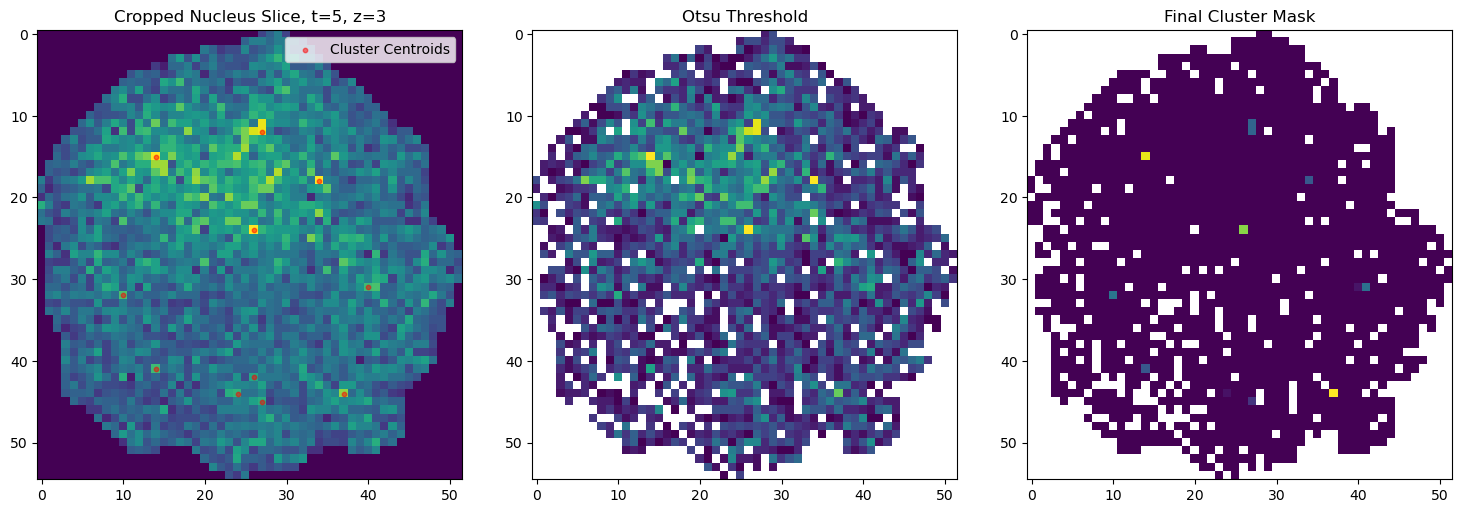

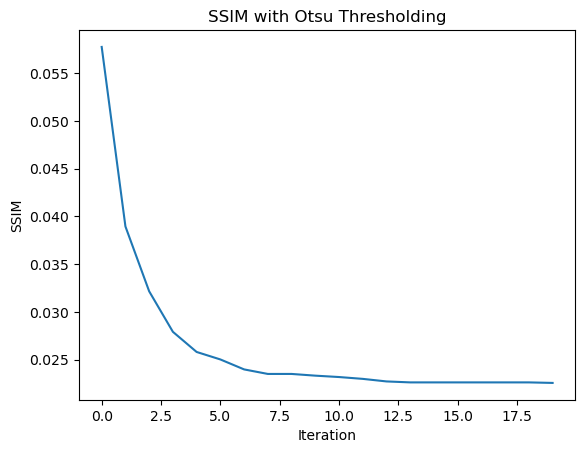

In [60]:
# Plot example of cluster segmentation
%matplotlib inline
# segment_clusters(dataset, nuclear_tracking, nuclear_channel,
#                  frame=4, nucleus_id=27,
#                  sigma_xy=1, z_plane=6
#                  , contour_cutoff=8, plot=True)

_, processed_slices = segment_clusters_otsu(dataset, nuclear_tracking, nuclear_channel,
                      frame=5, nucleus_id=27,
                      sigma_xy=0, z_plane=3,
                      window_size=20, iterations=20, plot=True)

# Binarize processed slices and compute structural similarity index SSIM with first entry
binarized_slices = [np.where(slice > 0, 1, 0) for slice in processed_slices]

# Compute SSIM with index 0
from skimage.metrics import structural_similarity as ssim

ssim_results = []
for i, slice_bin in enumerate(binarized_slices[1:], start=1):
    similarity = ssim(binarized_slices[0], slice_bin, data_range=1)
    ssim_results.append(similarity)

# Plot similarity
plt.plot(ssim_results)
plt.title("SSIM with Otsu Thresholding")
plt.xlabel("Iteration")
plt.ylabel("SSIM")
plt.show()

In [31]:
def plot_nucleus_time_z(dataset, nuclear_tracking, nuclear_channel, nucleus_id, start_frame, end_frame, start_z, end_z, sigma_xy=1):
    global_min, global_max = np.nanmin(dataset.channels_full_dataset[nuclear_channel]), 0.7*np.nanmax(dataset.channels_full_dataset[nuclear_channel])
    # Create a grid of subplots: time on horizontal axis, z on vertical axis
    fig, axs = plt.subplots(end_z - start_z + 1, end_frame - start_frame + 1, figsize=(15, 10))
    
    for z in range(start_z, end_z + 1):
        for t in range(start_frame, end_frame + 1):
            ax = axs[z - start_z, t - start_frame] if (end_z - start_z + 1 > 1 and end_frame - start_frame + 1 > 1) else axs
            
            cropped_nucleus_slice, _, _, _, min_y, max_y, min_x, max_x = process_nuclear_slice(
                nuclear_tracking.reordered_labels[t, :, :], 
                dataset.channels_full_dataset[nuclear_channel][t, :, :], 
                nucleus_id, sigma_xy, z
            )
            
            if cropped_nucleus_slice is not None:
                ax.imshow(cropped_nucleus_slice, cmap='viridis', vmin=global_min, vmax=global_max)
                ax.set_title(f"Time {t}, Z {z}", fontsize=8)  # Subplot title
            
            ax.axis('off')
    
    # Add a main title for the figure
    plt.suptitle(f"Nucleus {nucleus_id}: Time vs Z", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


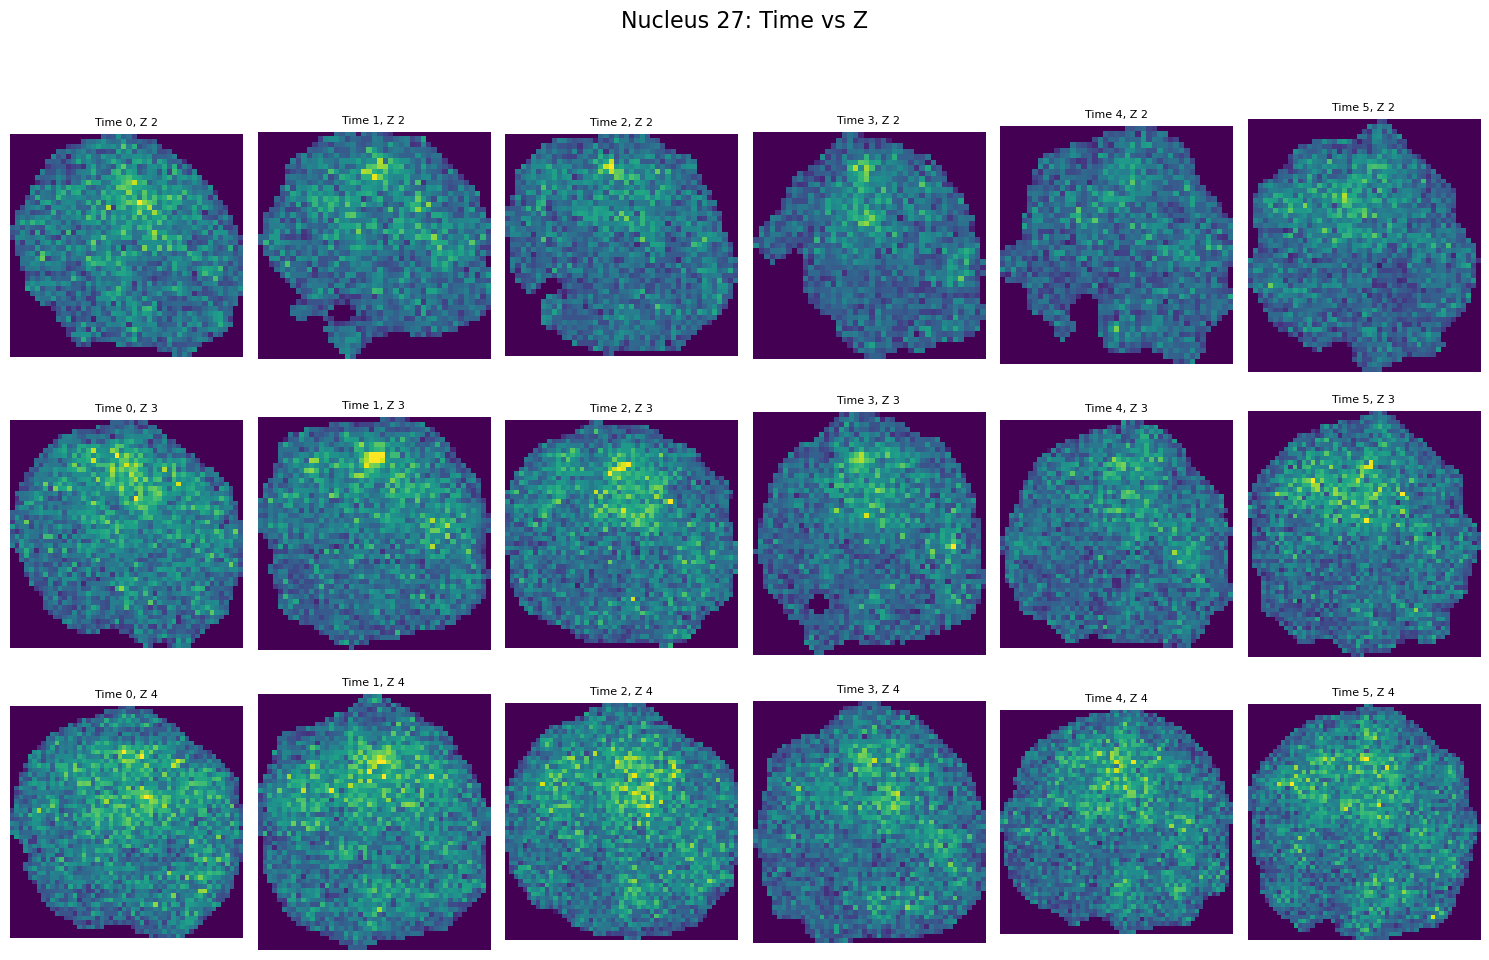

In [32]:
# Plot the raw data for nucleus 27 in time and at different z-planes
plot_nucleus_time_z(dataset, nuclear_tracking, nuclear_channel, nucleus_id=27, sigma_xy=1, start_frame=0, end_frame=5, start_z=2, end_z=4)